In [1]:
cd ..

/home/cody/inner-knowledge-pruning


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import torch
import copy
import glob
import torch.optim as optim
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report

from src.dataloader import make_data_loader
from src.model_loader import load_model
from src.trainers import first_eval, class_report
from src.analytics import fix_state_dict, df_builder

## Setup 

create student and teacher models. Load them onto device.
gather teacher predictions over validation set.

In [4]:
dataloaders, dataset_sizes = make_data_loader(8, 'cifar10')
student, teacher = load_model('models/baseline/cifar10/vgg16.pth', 'cifar10', 'vgg16')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

student = student.to(device)
teacher = teacher.to(device)

ground_labels, teacher_pred = class_report(teacher, dataloaders, dataset_sizes)
_, student_pred = class_report(student, dataloaders, dataset_sizes)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

report = classification_report(ground_labels, teacher_pred, target_names=class_names, output_dict=True)


Files already downloaded and verified
Files already downloaded and verified


Make PIE and classification report DF builder

In [5]:
dfs = df_builder(ground_labels, teacher_pred)

run model statistics over population for PIE and accuracy and ad them to data frame 

In [6]:
mag_30 = glob.glob('models/cifar10/vgg16/finegrain_mag/lr_0.01/alpha_1.0/sparsity_0.3/*.pt') 
mag_45 = glob.glob('models/cifar10/vgg16/finegrain_mag/lr_0.01/alpha_1.0/sparsity_0.45/*.pt')
mag_60 = glob.glob('models/cifar10/vgg16/finegrain_mag/lr_0.01/alpha_1.0/sparsity_0.6/*.pt')
mag_75 = glob.glob('models/cifar10/vgg16/finegrain_mag/lr_0.01/alpha_1.0/sparsity_0.75/*.pt')
mag_90 = glob.glob('models/cifar10/vgg16/finegrain_mag/lr_0.01/alpha_1.0/sparsity_0.9/*.pt')

models = [(mag_30, 30), (mag_45, 45), (mag_60, 60), (mag_75, 75), (mag_90, 90)]

for (paths, sparsity) in models:

    dfs.add_models(paths=paths, sparsity=sparsity, method='Finegrain Mag', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


/home/cody/inner-knowledge-pruning/src/analytics.py:98: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if method in pie_idx:


In [7]:
ik_45 = glob.glob('models/cifar10/vgg16/ik_finegrain_mag/lr_0.01/alpha_0.1/sparsity_0.45/*.pt')
ik_30 = glob.glob('models/cifar10/vgg16/ik_finegrain_mag/lr_0.01/alpha_0.1/sparsity_0.3/*.pt')
ik_60 = glob.glob('models/cifar10/vgg16/ik_finegrain_mag/lr_0.01/alpha_0.1/sparsity_0.6/*.pt')
ik_75 = glob.glob('models/cifar10/vgg16/ik_finegrain_mag/lr_0.01/alpha_0.1/sparsity_0.75/*.pt')
ik_90 = glob.glob('models/cifar10/vgg16/ik_finegrain_mag/lr_0.01/alpha_0.1/sparsity_0.9/*.pt')

models = [(ik_30, 30), (ik_45, 45), (ik_60, 60), (ik_75, 75), (ik_90, 90)]

for (paths, sparsity) in models:
    dfs.add_models(paths=paths, sparsity=sparsity, method='IK Finegrain Mag', student=student, 
                   dataloaders=dataloaders, dataset_sizes=dataset_sizes, class_names=class_names)


In [10]:
from sklearn.metrics import confusion_matrix
teacher_conf = confusion_matrix(ground_labels, teacher_pred)
FP_t = teacher_conf.sum(axis=0) - np.diag(teacher_conf)
FN_t = teacher_conf.sum(axis=1) - np.diag(teacher_conf)
TP_t = np.diag(teacher_conf)
TN_t = teacher_conf.sum() - (FP_t + FN_t + TP_t)

FPR_t = FP_t / (FP_t  + TN_t)
FNR_t = FN_t / (FN_t + TP_t)

In [36]:
IK_Stats = dfs.pruning_stats[np.logical_and(dfs.pruning_stats.method == 'IK Finegrain Mag', dfs.pruning_stats.sparsity == 90)]

mean_FPR_IK = IK_Stats.FP_r.mean(axis=0)
mean_FNR_IK = IK_Stats.FN_r.mean(axis=0)
FPR_IK_change = (mean_FPR_IK - FPR_t)/FPR_t * 100
FPN_IK_change = (mean_FNR_IK - FNR_t)/FNR_t * 100
print(FPR_IK_change)
print(FPN_IK_change)

[ 3.96341463 35.18518519 -1.28865979 -1.45348837 -2.52808989  3.30882353
 11.73469388  5.20833333 19.87179487 -9.04255319]
[-0.89285714  3.03030303  7.95454545  4.16666667 -4.16666667  1.52671756
 10.18518519 -1.44927536 -4.76190476 14.74358974]


In [37]:
Struct_Stats = dfs.pruning_stats[np.logical_and(dfs.pruning_stats.method == 'Finegrain Mag', dfs.pruning_stats.sparsity == 90)]
mean_FPR_Struct = Struct_Stats.FP_r.mean(axis=0)
mean_FNR_Struct = Struct_Stats.FN_r.mean(axis=0)
FPR_Struct_change = (mean_FPR_Struct - FPR_t)/FPR_t * 100
FPN_Struct_change = (mean_FNR_Struct - FNR_t)/FNR_t * 100
print(FPR_Struct_change)
print(FPN_Struct_change)

[-2.43902439 20.37037037  1.28865979 -0.14534884 -2.80898876  0.55147059
 22.95918367 18.75       16.66666667 12.76595745]
[ 8.92857143 20.45454545  5.22727273  3.7202381  -2.97619048  3.6259542
  4.16666667  1.08695652  3.57142857 12.82051282]


In [38]:
%config InlineBackend.figure_format = 'retina'

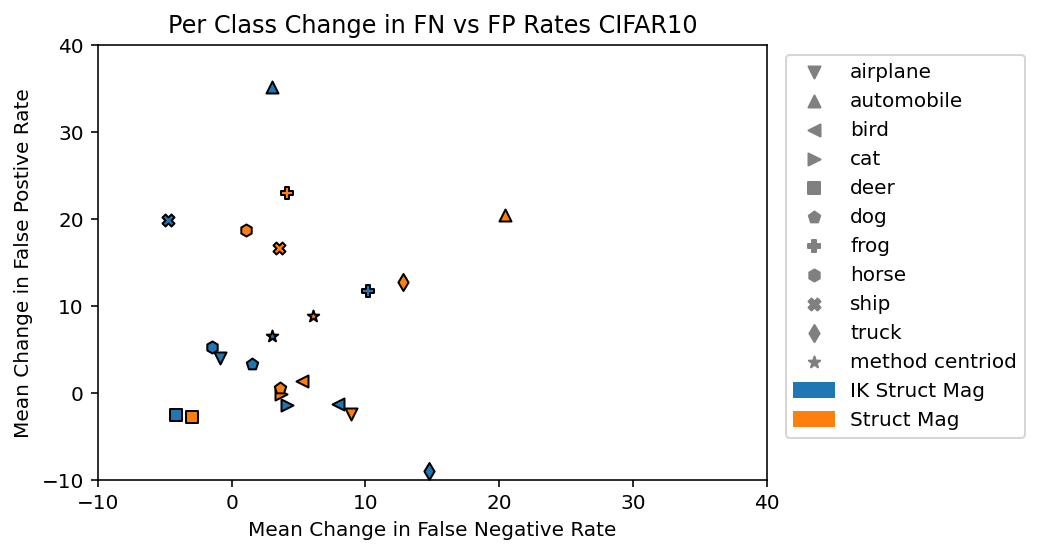

In [43]:
### FP Barchart

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import itertools

fig, ax = plt.subplots()
m = ("v", "^", "<", ">", "s", "p", "P", "h", "X", "d", "*")
markers = itertools.cycle(m)

handles = []
plt.xlim(-10, 40)
plt.ylim(-10, 40)
for x, y in zip(FPN_IK_change, FPR_IK_change):
    handles.append(plt.scatter(x, y, marker=next(markers), c='#1f77b4', edgecolors='black'))
#plt.scatter(FPR_IK_change, FPN_IK_change)
handles.append(plt.scatter(np.mean(FPN_IK_change), np.mean(FPR_IK_change), marker=next(markers), c='#1f77b4', edgecolors='black'))
for x, y in zip(FPN_Struct_change, FPR_Struct_change):
    plt.scatter(x, y, marker=next(markers), c='#ff7f0e', edgecolors='black')
# plt.scatter(FPR_Struct_change, FPN_Struct_change)
plt.scatter(np.mean(FPN_Struct_change), np.mean(FPR_Struct_change), marker=next(markers), c='#ff7f0e', edgecolors='black')

handles.append(mpatches.Patch(color="#1f77b4", label='IK Finegrain Mag'))
handles.append(mpatches.Patch(color="#ff7f0e", label='Finegrain Mag'))
ax.legend(handles, class_names+['method centriod','IK Struct Mag', 'Struct Mag'], bbox_to_anchor=(1.4, 1))
leg = ax.get_legend()
for handle in leg.legendHandles[:-2]:
    handle.set_color('grey')
plt.xlabel('Mean Change in False Negative Rate')
plt.ylabel('Mean Change in False Postive Rate')
plt.title("Per Class Change in FN vs FP Rates CIFAR10")
plt.show()


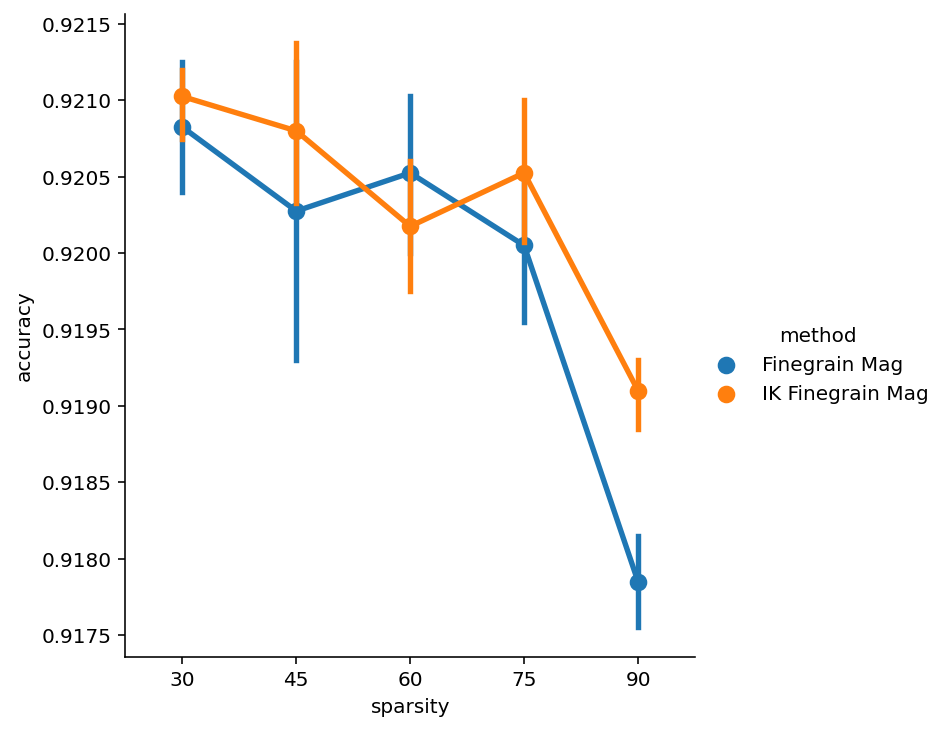

In [29]:
acc_plot = sns.catplot(x='sparsity', y='accuracy', hue='method', kind='point', data=dfs.pruning_stats)

acc_plot.savefig('figures/Acc_Fine.jpg', dpi=600)
acc_plot.savefig('figures/Acc_Fine.png', dpi=600)

In [ ]:
pie_fig = sns.catplot(x='sparsity', y='PIEs', hue='method', kind='point', data=dfs.PIEs)

pie_fig.savefig('figures/PIE_Fine.jpg', dpi=600)
pie_fig.savefig('figures/PIE_Fine.png', dpi=600)


In [10]:
finegrain_pie_90 = make_data_loader(8, dataset='cifar10', subset=dfs.pie_idx['finegrain_mag'][90])

Files already downloaded and verified


In [11]:
fg, ik = dfs.pie_idx['finegrain_mag'][90], dfs.pie_idx['ik_struct_mag'][90]

In [14]:
ik_not_fg = np.nonzero(np.isin(ik, fg, invert=True))[0]
fg_not_ik = np.nonzero(np.isin(fg, ik, invert=True))[0]
inter = np.intersect1d(ik, fg)
print(f'finegrain PIES: {fg.size}')
print(f'ik PIES: {ik.size}')
print(f'# in fg not in ik: {fg_not_ik.size}')
print(f'# in ik not in fg: {ik_not_fg.size}')
print(f'intersection : {inter.size}')

finegrain PIES: 168
ik PIES: 94
# in fg not in ik: 112
# in ik not in fg: 38
intersection : 56


In [15]:
inter_ds = make_data_loader(1, dataset='cifar10', subset=inter)
ik_ds = make_data_loader(1, dataset='cifar10', subset=ik)
fg_ds = make_data_loader(1, dataset='cifar10', subset=fg)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [18]:
ground_labels_inter, teacher_pred_inter = class_report(teacher, inter_ds[0], inter_ds[1])
report_inter = classification_report(ground_labels_inter, 
                                     teacher_pred_inter, 
                                     target_names=class_names, 
                                     output_dict=True)

ground_labels_ik, teacher_pred_ik = class_report(teacher, ik_ds[0], ik_ds[1])
report_ik = classification_report(ground_labels_ik, 
                                     teacher_pred_ik, 
                                     target_names=class_names, 
                                     output_dict=True)

ground_labels_fg, teacher_pred_fg = class_report(teacher, fg_ds[0], fg_ds[1])
report_fg = classification_report(ground_labels_fg, 
                                     teacher_pred_fg, 
                                     target_names=class_names, 
                                     output_dict=True)

In [19]:
print(f'intersection accuracy {report_inter["accuracy"]}')
print(f'IK PIES accuracy {report_ik["accuracy"]}')
print(f'SM PIES accuracy {report_fg["accuracy"]}')

intersection accuracy 0.375
IK PIES accuracy 0.40425531914893614
SM PIES accuracy 0.39880952380952384
